<b>Coding Assignment 5: Part 1<br>
CS 401: Quantum Computing <br>
Dr. Kell, Spring 2023 </b>

<b> Instructions </b> 

To complete the assignment, please fill in all coding cells as instructed below, and then submit the file on Notebowl once completed. Before you turn in your submission, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel → Restart) and then run all cells (in the menubar, select Cell → Run All). Make sure you fill in any place that says YOUR CODE GOES HERE.
    
<b> Constraints on references and collaborations</b>

<em>This is a Partner Assignment:</em> You will work on this assignment with a partner (submit one notebook file per group). 
    
 <item> <i> You and your partner may:</i> Reference any chapter from the course textbook, references, and relevant Wikipedia pages. You are permitted to discuss high-level ideas with other groups (but please do so sparringly). 
     
 <item> <i> You may not</i>: 
     
* You may not share code or work with other groups when writing your code.
<br> 
     
* Reference Qiskit's Grover's Algorithm guide.
    
<b> Finally: Be sure to use proper coding style for all your solutions!</b> For example, you should write docstrings for all functions, include useful in-line comments explaining how your code works, write clean code with readable variable names, etc.. You will lose points if you write sloppy code with poor style (e.g., not writing docstrings for any of your functions). 
    
Best of luck!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, cmath, math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401

## Part 1 [35 points]

Your overall goal in this assignment will be to implement a 3-SAT solver using Grover's algorithm. In this first part, you will adapt the quantum 3-SAT verifier we wrote in the <code>3-29_3SAT_verifier.ipynb</code> to now be the oracle gate you'll use in Grover's algorithm.   

In particular, first write the function <code>initialize_3sat_grovers_circuit(n, m)</code> that takes in two ints <code>n</code> and <code>m</code> and then constructs a circuit for an instance with <code>n</code> variables and <code>m</code> clauses. The function then returns a six tuple <code>(circ, x_reg, clause_ancilla, clause_outputs, y_reg, x_meas)</code> containing the overall QuantumCircuit <code>circ</code> as well as the registers in the circuit. These are the same QuantumRegisters used in verifier in <code>3-29_3SAT_verifier.ipynb</code> along with a ClassicalRegister <code>x_meas</code> that will store the final measurement result of Grover's algorithm. 

Note that circuit should initialize all ancilla qubits to state $|1\rangle$ and should put the <code>y_reg</code> qubit in state $|-\rangle$. (In the context of Grover's algorithm, <code>y_reg</code> is now the extra qubit used to create the action $|x\rangle \rightarrow (-1)^{f(x)}|x\rangle$ when applying the oracle.)

Next, write a function <code>add_3sat_oracle(circ, clauses, x_reg, clause_ancilla, clause_outputs, y_reg)</code> that takes in the six tuple return by <code>initialize_3sat_grovers_circuit(n, m)</code> and adds the oracle gate to <code>circ</code>, where the oracle assumes <code>x_reg</code> is state $|0\rangle$ and the ancilla registers are in state $|1\rangle$ at the outset.

You can use a similar approach/code to the verifier in <code>3-29_3SAT_verifier.ipynb</code>. However, since the oracle will be applied multiple times in Grover's algorithm, one key difference is that all registers (except for <code>y_reg</code>) <i>need to be reset to their original state at the end of the circuit</i>. In particular, <code>x_reg</code> should be reset to state $|0\rangle$ and the ancillas should be reset to state $|1\rangle$. You will need to think carefully about how this can be accomplished using only quantum gates.

In [2]:
def initialize_3sat_grovers_circuit(n, m):
    # initalize circuit objects
    x_reg = QuantumRegister(n, 'x')
    clause_ancilla = QuantumRegister(m, 'c ancils')
    clause_outputs = QuantumRegister(m, 'c outputs') 
    y_reg = QuantumRegister(1, 'y')
    x_meas = ClassicalRegister(n, 'x_meas')
    circ = QuantumCircuit(x_reg, clause_ancilla, clause_outputs, y_reg, x_meas)
    
    # set up ancilla registers
    for c in range(m):
        circ.x(clause_ancilla[c])
        circ.x(clause_outputs[c])
    
    # set of result qubit in state |->
    circ.x(y_reg)
    circ.h(y_reg)
    return (circ, x_reg, clause_ancilla, clause_outputs, y_reg, x_meas) 

def or_gate(circ, a, b, result):
    '''
    Adds an OR gate to a quantum circuit.
    
    Args:
        QuantumRegisters a, b, and result (result is in state |1>)
    @return:
        a OR b is stored on result. a and b contain original values
    '''
    circ.x(a)
    circ.x(b) 
    circ.ccx(a, b, result)
    circ.x(a)
    circ.x(b)    
    
def set_clause_reg(circ, clause, x_reg):
    for var in set(clause):
        if var < 0: 
            index = -var - 1
            circ.x(x_reg[index])
    
def add_clause(circ, x_reg, clause, c_index, clause_ancilla, clause_outputs):
    '''
    Adds an OR gate to a quantum circuit.
    
    Args:
        QuantumRegisters a, b, and result (result is in state |1>)
    @return:
        a OR b is stored on result. a and b contain original values
    '''
    # negate variables in the circuit that are negative in clause 
    set_clause_reg(circ, clause, x_reg)
    
    # perform the OR operations in the clause
    r1, r2, r3 = abs(clause[0])-1, abs(clause[1])-1, abs(clause[2])-1 
    or_gate(circ, x_reg[r1], x_reg[r2], clause_ancilla[c_index]) 
    or_gate(circ, x_reg[r3], clause_ancilla[c_index], clause_outputs[c_index])
    
    # reset the negated literal to their original values
    set_clause_reg(circ, clause, x_reg)
            
            
def undo_clause(circ, x_reg, clause, c_index, clause_ancilla, clause_outputs):
    '''Does add_clause in reverse'''
    # negate variables in the circuit that are negative in clause 
    set_clause_reg(circ, clause, x_reg)
    
    # perform the OR operations in the clause
    r1, r2, r3 = abs(clause[0])-1, abs(clause[1])-1, abs(clause[2])-1 
    or_gate(circ, x_reg[r3], clause_ancilla[c_index], clause_outputs[c_index])
    or_gate(circ, x_reg[r1], x_reg[r2], clause_ancilla[c_index]) 
    
    # reset the negated literal to their original values
    set_clause_reg(circ, clause, x_reg)
            

def uncompute_3sat_oracle(circ, clauses, x_reg, clause_ancilla, clause_outputs):
    # check to see if all clauses were satisfied 
    # reset clause varibles
    m = len(clauses)
    for c in range(m-1, -1, -1):
        clause = clauses[c]
        undo_clause(circ, x_reg, clause, c, clause_ancilla, clause_outputs)
        
def add_3sat_oracle(circ, clauses, x_reg, clause_ancilla, clause_outputs, y_reg):
    '''
    Constructs a quantum circuit that verifies a 3-SAT instance
    
    Args:
        clauses: list of tuples specifying clauses in DIMACS notation
        assignment: list of Booleans specifying variable assignment
    Returns:
        circ: QuantumCircuit object verifies if assignment satisfies the formula 
    '''
    m = len(clauses)
    # add clause sub-circuits
    for c in range(m):
        clause = clauses[c]
        add_clause(circ, x_reg, clause, c, clause_ancilla, clause_outputs)
        
    # check to see if all clauses were satisfied 
    circ.mct(clause_outputs, y_reg)
    
    # uncompute oracle circuit (reset to orginal values)
    uncompute_3sat_oracle(circ, clauses, x_reg, clause_ancilla, clause_outputs)

## Part 2 [15 points]

You will now complete the implementation of Grover's algorithm. In particular, write the following functions: 

* <code>add_diffuser(circ, vars_reg, n)</code>: takes in overall QuantumCircuit object <code>circ</code>, the QuantumRegister <code>x_reg,</code>, and the number of variables <code>n</code>. The function then adds gates to <code>circ</code> that apply diffusion operation done in the second half of each Grover iteration. Note that likely the easiest way to create the "phase shift" gate is to use the QuantumCircuit method <code>unitary(matrix, reg)</code> that takes in a 2D-list (or numpy matrix) <code>matrix</code> and a QuantumRegister <code>reg</code> and adds a quantum gate to the circuit that applies the operation given by <code>matrix</code> to register <code>reg</code>.


* <code>three_sat_grovers(clauses, n, trials)</code>: top-level function that repeatedly solves a 3-SAT instance using Grover's algorithm (using the <code>add_diffuser()</code> function and the functions written in Part 1). <code>clauses</code> is a list containing tuples specifying the instance in DIMACS notation, <code>n</code> is the number of variables in the instance, and <code>trials</code> is the number of times the algorithm is executed. The function then returns a dictionary that maps <code>x_meas</code> outcomes to their frequencies (you can obtain this dictionary using the <code>get_counts()</code> method on the result object returned by the circuit simulation). 


In [3]:
def add_diffuser(circ, x_reg, n):
    phase_gate = np.zeros((2**n, 2**n))
    phase_gate[0][0] = 1
    for i in range(1, 2**n):
        phase_gate[i][i] = -1 
        
    circ.h(x_reg)
    circ.unitary(phase_gate, x_reg)
    circ.h(x_reg)
    
def three_sat_grovers(clauses, n, trials):
    ''' 
    Evaluates a 3-SAT instance in CNF with n variables and m clauses
    for a fixed assignment of the Boolean variables in the formula. 
    
    Args
        clauses: a list of 3-tuples specifying the formula in DIMACS notation
        assignment: a list of Booleans (assignment[0] = True -> x_1 = True)
    Returns: 
        True if the formulas evalutes to True; otherwise returns False. 
    '''
    R = int(math.sqrt(2**n))
    m = len(clauses)
    circ, x_reg, clause_ancilla, clause_outputs, y_reg, x_meas = initialize_3sat_grovers_circuit(n, m)
    
    circ.h(x_reg)
    for repeat in range(R):
        add_3sat_oracle(circ, clauses, x_reg, clause_ancilla, clause_outputs, y_reg)
        add_diffuser(circ, x_reg, n)
               
    circ.measure(x_reg, x_meas)
    result = qis401.simulate_circuit(circ, trials)
    return result.get_counts() 

### Testing Your Solution

You can use the below function <code>plot_unique_3sat_grovers(trials)</code> to test your implementation. The function runs your circuit on the eight possible 3-variable 3-SAT instances (with unique solutions) for <code>trials</code> number of times each. The function then plots the output frequencies for each instance. For 100 trials, your output should look similar to following:

<div align="center">
<img src="3sat-bar-graph-test.png" width="700">
</div>

You should also write a few additional tests to double check that your implementation is correct. 

In [4]:
# 3-variable 3-SAT instances tested by plot_unique_3sat_grovers()
_instances = [
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, -3), (-1, 2, 3), (1, -2, -3), (1, -2, 3), (1, 2, -3)],
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, -3), (-1, 2, 3), (1, -2, -3), (1, -2, 3), (1, 2, 3)],
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, -3), (-1, 2, 3), (1, -2, -3), (1, 2, -3), (1, 2, 3)],
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, -3), (-1, 2, 3), (1, -2, 3), (1, 2, -3), (1, 2, 3)],
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, -3), (1, -2, -3), (1, -2, 3), (1, 2, -3), (1, 2, 3)],
    [(-1, -2, -3), (-1, -2, 3), (-1, 2, 3), (1, -2, -3), (1, -2, 3), (1, 2, -3), (1, 2, 3)],
    [(-1, -2, -3), (-1, 2, -3), (-1, 2, 3), (1, -2, -3), (1, -2, 3), (1, 2, -3), (1, 2, 3)],
    [(-1, -2, 3), (-1, 2, -3), (-1, 2, 3), (1, -2, -3), (1, -2, 3), (1, 2, -3), (1, 2, 3)],
]

def plot_unique_3sat_grovers(trials):
    ''' 
    Tests Grover's algorithm for each of the possible 3-variable 
    3-SAT instances with unique solutions and plots the results. 
    
    Args: int trials (number of trials per instance)
    @return: plots a bar graph for output frequencies for each instance
    '''
    
    # execute grovers on each instance and keep track output dictionaries
    # (there will be 8 total plots, displayed in 2x4 grid)
    n, num_rows, num_cols = 3, 2, 4
    output_dicts = [[None for col in range(num_cols)] for row in range(num_rows)]
    for index in range(len(_instances)):
        out_dict = three_sat_grovers(_instances[index], n, trials)
        row, col = index//num_cols, index % num_cols
        output_dicts[row][col] = out_dict 
        
    # use dictionaries to display plots
    width, height = 15, 5
    outputs = ['000', '001', '010', '011', '100', '101', '110', '111']
    fig, ax = plt.subplots(num_rows, num_cols)
    fig.set_figwidth(width) 
    fig.set_figheight(height)
    for row in range(num_rows):
        for col in range(num_cols):
            cur_dict = output_dicts[row][col] 
            counts = [cur_dict[out[::-1]] if out[::-1] in cur_dict else 0 for out in outputs] 
            ax[row, col].set_xticks(range(8))
            ax[row, col].set_xticklabels(outputs, rotation = 300, fontsize = 'small' )
            ax[row, col].bar(outputs, counts)

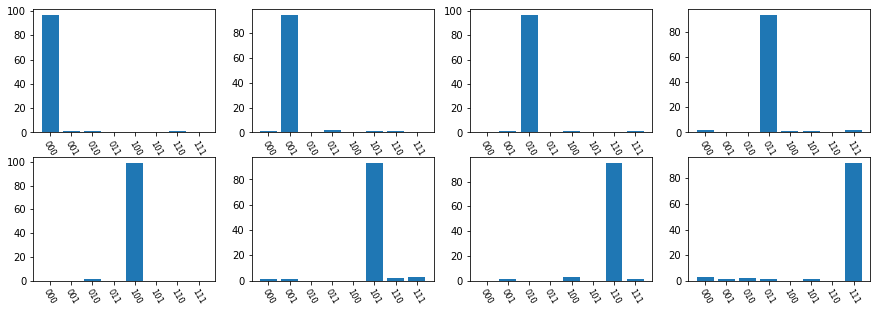

In [5]:
plot_unique_3sat_grovers(100)

In [6]:
# ADDITIONAL TESTS GO HERE (DELETE THIS COMMENT)